In [11]:
%pylab
%matplotlib inline
from scipy.optimize import newton
from numba import njit

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


/home/mike/.conda/envs/idp/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['axes']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Let's write all the different integration steppers, as well as a rudimentary ODE driver routine that can use any of them

In [19]:
@njit
def SpringDeriv(y, t):
# Here we're putting this in a framework similar to a general-purpose ODE integrator, so we could plug and play with 
# off-the-shelf solvers if we really wanted to
    return np.array([y[1], -y[0]])

def EulerStep(deriv, yold, t, dt):
    return yold + deriv(yold, t) * dt

def SymplecticEulerStep(deriv, yold, t, dt):
    y = np.copy(yold)
    y[0] += dt * y[1]
    y[1] -= dt * y[0]
    return y

def ImplicitEulerStepSpring(deriv, yold, t, dt):
#NOTE: this is only the implicit step for the special case of the spring problem
    return (yold + deriv(yold, t) * dt) / (1 + dt*dt)

def ImplicitEulerStep(deriv, yold, t, dt):
    # we're gonna be fancy here and do a general-purpose implicit solve
    x1 = yold + deriv(yold, t) * dt # need a second guess for the solve iteration
    x0 = yold + deriv(yold, t) * dt * 0.9
    # want to solve yold + dt * deriv(y, t+dt) = y for y
    func = lambda y: y - yold - deriv(y, t + dt) * dt
    sol = newton(func, x1, x1 = x0, tol=1e-15, maxiter=10**4) # this solves the implicit equation with the secant method
    return sol

def odeint(func, y0, Tmax, dt, stepper='Euler'):
    stepper = steppers[stepper] # get the actual stepper function
    
    y = [y0,]
    t = [0,]
    Nsteps = int(Tmax/dt + 0.5)
    
    stepper
    for i in range(Nsteps):
        y.append(stepper(func, y[-1],t[-1],dt))
        t.append((i+1) * dt)
    return np.array(t), np.array(y)

steppers = {"Euler": EulerStep,
            "Symplectic": SymplecticEulerStep,
            "Implicit": ImplicitEulerStepSpring
           }

Now we'll solve the spring problem using all methods. Note that the analytic solution for this particular initial condition is just cos(t)

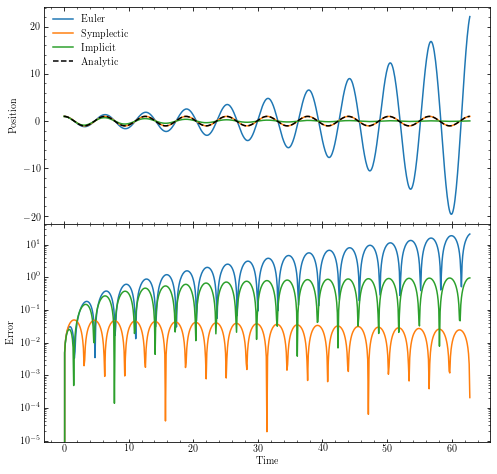

In [20]:
deriv = lambda x, t: np.array([x[1], -x[0]])

y0 = np.array([1., 0.])
Tmax = 2*np.pi*10

fig, axes = plt.subplots(2, sharex=True, figsize=(8,8))

for name in steppers.keys():
    t, y = odeint(deriv, y0, Tmax, 0.1, stepper=name)
    axes[0].plot(t, y[:,0], label=name)
    axes[1].plot(t, np.abs(y[:,0]-np.cos(t)),label=name)
axes[0].plot(t, np.cos(t), label="Analytic", ls='dashed', color='black')
axes[1].set_yscale('log')
axes[1].set_xlabel("Time")
axes[0].set_ylabel("Position")
axes[0].legend()
axes[1].set_ylabel("Error")
fig.subplots_adjust(wspace=0, hspace=0)
plt.show()

We see that the explicit Euler blows up, the implicit decays, and the symplectic conserves energy on average. Now let's analyze the nature of the truncation errors.

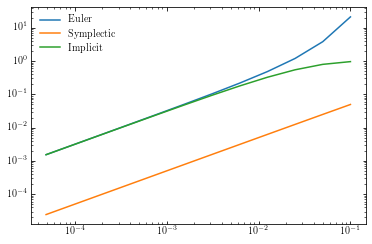

In [23]:
dts = 0.1 / (1 << np.arange(12)) # range of timesteps we'll try

errors = {}
for m in steppers.keys():
    errors[m] = []
    for dt in dts:
        t, y = odeint(deriv, y0, Tmax, dt, stepper=m)
        errors[m].append(np.max(np.abs(y[:,0]-np.cos(t))))
    #t_euler, y_euler = Euler(deriv, y0, dt, Tmax)
    #t_mid, y_mid = Midpoint(deriv, y0, dt, Tmax)
    plt.plot(dts, errors[m], label=m)
plt.loglog()
plt.legend()
plt.show()

We see that all methods are first order, just with different coefficients on the leading error term. Moreover, the normalization on the symplectic method appears to be particularly tiny! 

Now let's have a look at the energy error.

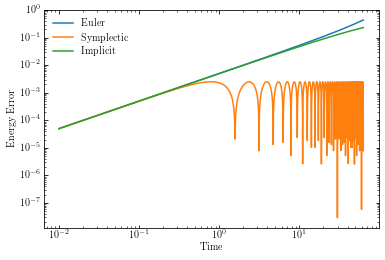

In [29]:
dt = 0.01

errors = {}
for m in steppers.keys():
    t, y = odeint(deriv, y0, Tmax, dt, stepper=m)
    plt.plot(t, np.abs(0.5*y[:,0]*y[:,0] + 0.5*y[:,1]*y[:,1] - 0.5), label=m)
plt.xlabel("Time")
plt.ylabel("Energy Error")
plt.loglog()
#plt.yscale('log')
plt.legend()
plt.show()

First-order energy errors are present in all methods, but the symplectic method's appear to be stable.

Finally, let's look at the phase-space diagrams.

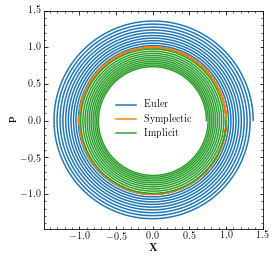

In [33]:
dt = 0.01

errors = {}
for m in steppers.keys():
    t, y = odeint(deriv, y0, Tmax, dt, stepper=m)
    plt.plot(y[:,0], y[:,1], label=m)
plt.xlabel(r"${\bf X}$")
plt.ylabel(r"${\bf p}$")
plt.axes().set_aspect('equal')
#plt.loglog()
#plt.yscale('log')
plt.legend()
plt.show()

Explicit Euler increases the phase-space area, implicit decreases it, and symplectic conserves it.